In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [6]:
X, Y = np.load("x_coffee_data.npy"), np.load("y_coffee_data.npy")
print(X.shape, Y.shape)

(200, 2) (200, 1)


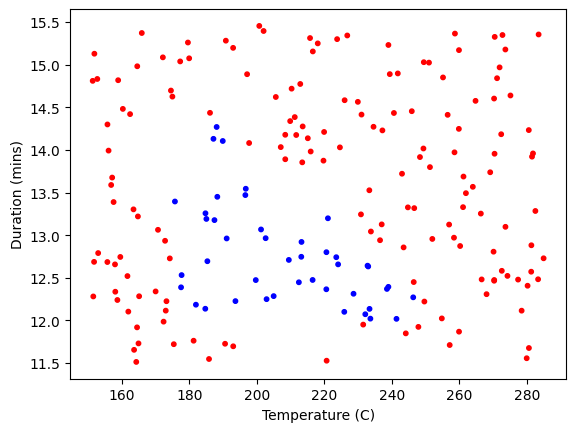

In [25]:
colors = []
for i in range(len(Y)):
    if Y[i] < 1e-4:
        colors.append("red")
    else:
        colors.append("blue")

plt.scatter(X[:, 0], X[:, 1], s=10, c=colors, marker='o')
plt.xlabel("Temperature (C)")
plt.ylabel("Duration (mins)")
plt.show()

In [26]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [27]:
Xt = np.tile(Xn, (1000,1))
Yt = np.tile(Y, (1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


In [28]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


In [31]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.8332983   0.30262494 -0.67795956]
 [ 0.41676605  0.38920617  0.11734831]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-1.0206949 ]
 [ 0.04910743]
 [-0.36368406]] 
b2(1,): [0.]


In [32]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 238us/step - loss: 0.3001
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 230us/step - loss: 0.1308
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 248us/step - loss: 0.1192
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step - loss: 0.1063
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step - loss: 0.0236
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step - loss: 0.0132
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 238us/step - loss: 0.0090
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 229us/step - loss: 0.0063
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - loss: 0.0045
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 227us/step - loss: 0.0032


In [33]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-10.564177    -0.0581065   14.0527    ]
 [ -0.18138982  -8.815638    11.744491  ]] 
b1: [-11.570273  -11.032398    1.6645143]
W2:
 [[-44.745052]
 [-40.742645]
 [-39.728073]] 
b2: [23.178173]


In [34]:
X_test = np.array([
    [200, 13.9],  # positive example
    [200, 17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predictions = 
 [[9.6813399e-01]
 [6.2820696e-08]]


In [36]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


In [3]:
X_train, y_train = np.load("x_multiclass_data.npy"), np.load("y_multiclass_data.npy")
print(X_train.shape, y_train.shape)

(100, 2) (100,)


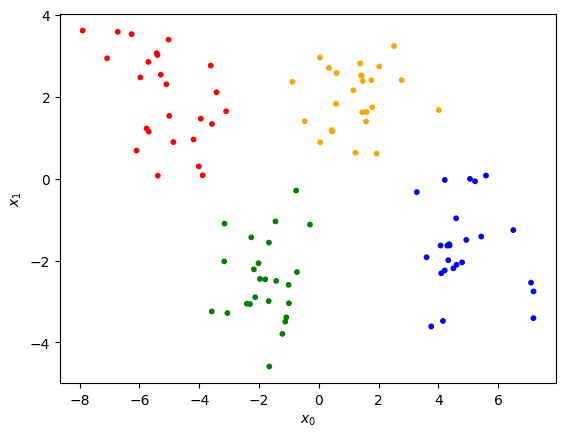

In [11]:
colors = []
for i in range(len(y_train)):
    if y_train[i] < 0.1:
        colors.append("red")
    elif 0.1 < y_train[i] < 1.9:
        colors.append("green")
    elif 1.9 < y_train[i] < 2.9:
        colors.append("orange")
    else:
        colors.append("blue")

plt.scatter(X_train[:, 0], X_train[:, 1], s=10, c=colors, marker='o')
plt.xlabel(r"$x_{0}$")
plt.ylabel(r"$x_{1}$")
plt.show()

In [12]:
# show classes in data set
print(f"unique classes {np.unique(y_train)}")
# show how classes are represented
print(f"class representation {y_train[:10]}")
# show shapes of our dataset
print(f"shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}")

unique classes [0 1 2 3]
class representation [3 3 3 0 3 3 3 3 2 0]
shape of X_train: (100, 2), shape of y_train: (100,)


In [13]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        Dense(2, activation = 'relu',   name = "L1"),
        Dense(4, activation = 'linear', name = "L2")
    ]
)

In [14]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

model.fit(
    X_train,y_train,
    epochs=200
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8735  
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 1.7381
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.6261
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 1.5273
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 1.4400
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1.3627
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2936
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 1.2312
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 1.1739
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 1.1194
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.0677
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 1.0173
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 0.9670
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.9172
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.8656
Epoch 

In [15]:
l1 = model.get_layer("L1")
W1,b1 = l1.get_weights()